In [1]:
import pandas as pd
import numpy as np
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
import re
import geopandas as gpd
from shapely.geometry import Point
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity, NearestNeighbors
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

In [2]:
data = pd.read_csv("/Users/gavinpryor/.cache/kagglehub/datasets/sobhanmoosavi/us-accidents/versions/13/US_Accidents_March23.csv")
#data = pd.read_csv("/Users/Randy/.cache/kagglehub/datasets/sobhanmoosavi/us-accidents/versions/13/US_Accidents_March23.csv")

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
data.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Street,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,Right lane blocked due to accident on I-70 Eas...,I-70 E,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,10.0,Calm,NaN,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,Accident on Brice Rd at Tussing Rd. Expect del...,Brice Rd,Reynoldsburg,Franklin,OH,43068-3402,US,US/Eastern,KCMH,2016-02-08 05:51:00,37.9,NaN,100.0,29.65,10.0,Calm,NaN,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,Accident on OH-32 State Route 32 Westbound at ...,State Route 32,Williamsburg,Clermont,OH,45176,US,US/Eastern,KI69,2016-02-08 06:56:00,36.0,33.3,100.0,29.67,10.0,SW,3.5,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,Accident on I-75 Southbound at Exits 52 52B US...,I-75 S,Dayton,Montgomery,OH,45417,US,US/Eastern,KDAY,2016-02-08 07:38:00,35.1,31.0,96.0,29.64,9.0,SW,4.6,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,Accident on McEwen Rd at OH-725 Miamisburg Cen...,Miamisburg Centerville Rd,Dayton,Montgomery,OH,45459,US,US/Eastern,KMGY,2016-02-08 07:53:00,36.0,33.3,89.0,29.65,6.0,SW,3.5,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day


In [5]:
data.columns

Index(['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description',
       'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

## Data Cleaning and Preprocessing

In [6]:
# drop unnessecary columns
cleaned = data.drop(columns={
    #'ID',
    'Source',
    'End_Lat',
    'End_Lng',
    'End_Time',
    'Distance(mi)',
    'Description',
    'Street',
    'City',
    'Country',
    'County',
    'State',
    'Zipcode',
    'Country',
    'Timezone',
    'Airport_Code',
    'Weather_Timestamp',
    'Amenity',
    'Civil_Twilight',
    'Nautical_Twilight',
    'Astronomical_Twilight'
})

In [7]:
cleaned.head()

,ID,Severity,Start_Time,Start_Lat,Start_Lng,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset
0,A-1,3,2016-02-08 05:46:00,39.865147,-84.058723,36.9,NaN,91.0,29.68,10.0,Calm,NaN,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,Night
1,A-2,2,2016-02-08 06:07:59,39.928059,-82.831184,37.9,NaN,100.0,29.65,10.0,Calm,NaN,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,Night
2,A-3,2,2016-02-08 06:49:27,39.063148,-84.032608,36.0,33.3,100.0,29.67,10.0,SW,3.5,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,True,False,Night
3,A-4,3,2016-02-08 07:23:34,39.747753,-84.205582,35.1,31.0,96.0,29.64,9.0,SW,4.6,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,Night
4,A-5,2,2016-02-08 07:39:07,39.627781,-84.188354,36.0,33.3,89.0,29.65,6.0,SW,3.5,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,True,False,Day


In [8]:
cleaned.isnull().sum()

ID                         0
Severity                   0
Start_Time                 0
Start_Lat                  0
Start_Lng                  0
Temperature(F)        163853
Wind_Chill(F)        1999019
Humidity(%)           174144
Pressure(in)          140679
Visibility(mi)        177098
Wind_Direction        175206
Wind_Speed(mph)       571233
Precipitation(in)    2203586
Weather_Condition     173459
Bump                       0
Crossing                   0
Give_Way                   0
Junction                   0
No_Exit                    0
Railway                    0
Roundabout                 0
Station                    0
Stop                       0
Traffic_Calming            0
Traffic_Signal             0
Turning_Loop               0
Sunrise_Sunset         23246
dtype: int64

In [9]:
numeric = [
    'Severity',
    'Start_Lat',
    'Start_Lng',
    'Temperature(F)',
    'Wind_Chill(F)',
    'Humidity(%)',
    'Pressure(in)',
    'Visibility(mi)',
    'Wind_Speed(mph)',
    'Precipitation(in)'
]

categorical = [
    'Wind_Direction',
    'Weather_Condition',
    'Bump',
    'Crossing',
    'Give_Way',
    'Junction',
    'No_Exit',
    'Railway',
    'Roundabout',
    'Station',
    'Stop',
    'Traffic_Calming',
    'Traffic_Signal',
    'Turning_Loop',
    'Sunrise_Sunset'
]

datetime = [
    'Start_Time'
]

In [10]:
# handle nulls
for col in numeric:
    cleaned[col] = cleaned[col].fillna(cleaned[col].median())

for col in categorical:
    cleaned[col] = cleaned[col].fillna('Unknown')

### Remove outliers or weird values

In [11]:
# only keep lat and lng within the usa
cleaned = cleaned[(cleaned['Start_Lat'].between(20, 50)) & (cleaned['Start_Lng'].between(-130, -60))]

# keep possible weather values
cleaned = cleaned[(cleaned['Temperature(F)'] > -50) & (cleaned['Temperature(F)'] < 130)]
cleaned = cleaned[(cleaned['Visibility(mi)'] <= 50)]
cleaned = cleaned[(cleaned['Wind_Speed(mph)'] < 120)]

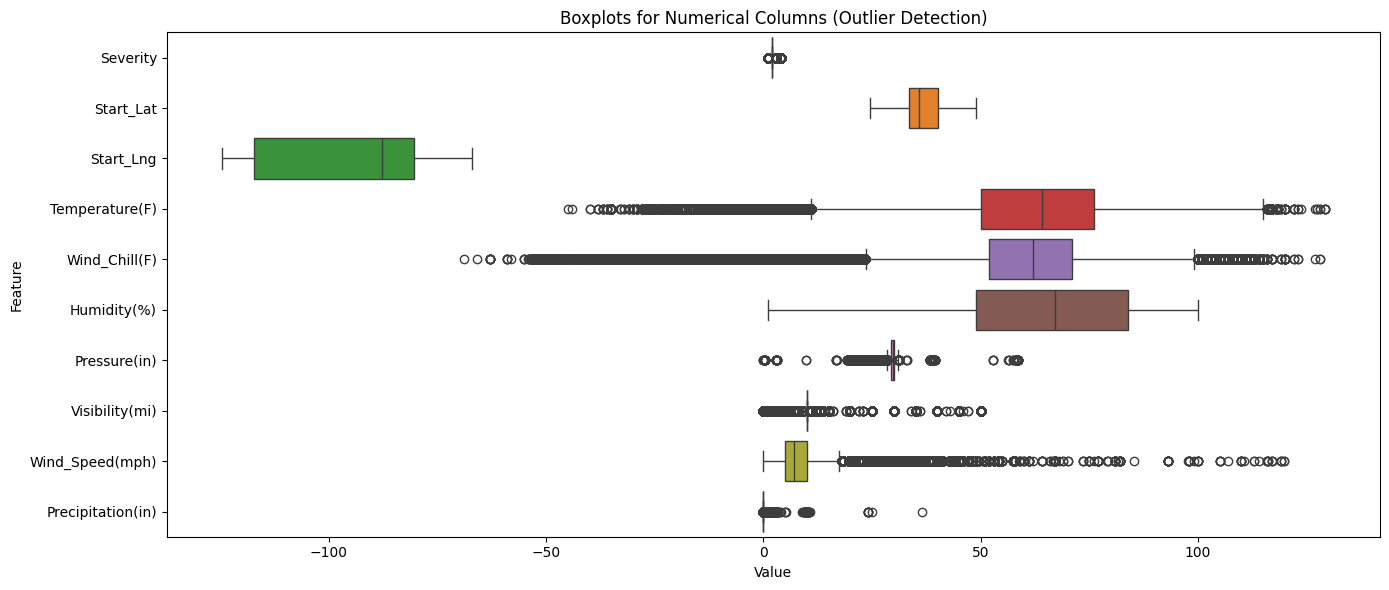

In [12]:
# plot numeric features to check for outliers
plt.figure(figsize=(14, 6))
sns.boxplot(data=cleaned[numeric], orient='h', showfliers=True)

plt.title("Boxplots for Numerical Columns (Outlier Detection)")
plt.xlabel("Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [13]:
# handle duplicates
cleaned = cleaned.drop_duplicates()

In [14]:
for col in categorical:
    print(f"\n--- {col} ---")
    print(cleaned[col].value_counts(dropna=False))


--- Wind_Direction ---
Wind_Direction
CALM        961514
S           419949
SSW         384808
W           383866
WNW         378689
NW          369211
Calm        368461
SW          364433
WSW         353742
SSE         349074
NNW         333373
N           307125
SE          294820
E           278877
ESE         268275
NE          258620
ENE         258450
NNE         255289
VAR         250506
South       177360
Unknown     175203
West        164697
North       153354
Variable    113965
East        103529
Name: count, dtype: int64

--- Weather_Condition ---
Weather_Condition
Fair                                   2560503
Mostly Cloudy                          1015963
Cloudy                                  817058
Clear                                   808644
Partly Cloudy                           698670
Overcast                                382856
Light Rain                              352954
Scattered Clouds                        204736
Unknown                                

In [15]:
def clean_weather_condition(data, col='Weather_Condition'):
    s = (
        data[col].fillna('Unknown')
        .astype(str)
        .str.strip()
    )
    s = s.str.replace(r'\s+', ' ', regex=True)
    s = s.str.replace(r'\s*/\s*', ' / ', regex=True)  # normalize " / "
    s_lower = s.str.lower()

    # separating out weather conditions
    windy_flag    = s_lower.str.contains(r'\bwindy\b')
    heavy_flag    = s_lower.str.contains(r'\bheavy\b')
    light_flag    = s_lower.str.contains(r'\blight\b')
    thunder_flag = s_lower.str.contains(r'\b(?:t-?storm|thunder)\b', regex=True)


    base = s_lower
    base = base.str.replace(r'\bwindy\b', '', regex=True)
    base = base.str.replace(r'\bheavy\b', '', regex=True)
    base = base.str.replace(r'\blight\b', '', regex=True)
    base = base.str.replace(r'\bpatch(es)? of\b', '', regex=True)
    base = base.str.replace(r'\bshallow\b', '', regex=True)
    base = base.str.replace(r'\bblowing\b', '', regex=True)
    base = base.str.replace(r'\bdrifting\b', '', regex=True)
    base = base.str.replace(r'\blow\b', '', regex=True)
    base = base.str.replace(r'\bnearby\b', '', regex=True)
    base = base.str.replace(r'\bin the vicinity\b', '', regex=True)
    base = base.str.replace(r'\bn/a precipitation\b', 'unknown', regex=True)

    # collapse slashes to spaces after removals
    base = base.str.replace(r'\s*/\s*', ' ', regex=True)
    base = base.str.replace(r'\s+', ' ', regex=True).str.strip()

    # reduce the number of categories
    def to_category(txt: str) -> str:
        if txt in ('unknown', ''):
            return 'Unknown'
        if re.search(r'\b(wintry mix|rain and snow|snow and rain|snow and sleet|sleet and snow|freezing drizzle|freezing rain|freezing fog|ice pellets)\b', txt):
            if re.search(r'\b(freezing rain|freezing drizzle|freezing fog|ice pellets)\b', txt):
                return 'Freezing / Ice'
            return 'Wintry Mix'
        if re.search(r'\b(t-?storm|thunderstorm|thunder)\b', txt):
            return 'Thunderstorm'
        if re.search(r'\b(snow grains|snow showers?|snow)\b', txt):
            return 'Snow'
        if re.search(r'\bsleet\b', txt):
            return 'Sleet'
        if re.search(r'\bhail\b', txt):
            return 'Hail'
        if re.search(r'\b(drizzle)\b', txt):
            return 'Drizzle'
        if re.search(r'\b(rain showers?|showers?)\b', txt):
            return 'Rain'
        if re.search(r'\brain\b', txt):
            return 'Rain'
        if re.search(r'\b(fog|mist)\b', txt):
            return 'Fog / Mist'
        if re.search(r'\bhaze\b', txt):
            return 'Haze'
        if re.search(r'\b(smoke)\b', txt):
            return 'Smoke'
        if re.search(r'\b(dust(storm)?|dust whirls?)\b', txt):
            return 'Dust'
        if re.search(r'\b(sand)\b', txt):
            return 'Sand'
        if re.search(r'\bsqualls?\b', txt):
            return 'Squalls'
        if re.search(r'\b(tornado|funnel cloud)\b', txt):
            return 'Tornado'
        if re.search(r'\bovercast\b', txt):
            return 'Overcast'
        if re.search(r'\b(scattered clouds|mostly cloudy|partly cloudy|cloudy)\b', txt):
            return 'Cloudy'
        if re.search(r'\b(clear|fair)\b', txt):
            return 'Clear'
        if re.search(r'\b(volcanic ash)\b', txt):
            return 'Other'
        return 'Other'

    cleaned_cat = base.apply(to_category)

    # intensity of weather
    intensity = np.where(heavy_flag, 'Heavy',
                  np.where(light_flag, 'Light', 'Normal'))

    out = data.copy()
    out['Weather_Clean'] = cleaned_cat
    out['Weather_Windy'] = windy_flag.astype(int)
    out['Weather_Thunder'] = thunder_flag.astype(int)
    out['Weather_Intensity'] = intensity.astype(str)
    return out

In [16]:
cleaned = clean_weather_condition(cleaned, col='Weather_Condition')

print(cleaned['Weather_Clean'].value_counts())

Weather_Clean
Clear             3404762
Cloudy            2780171
Rain               493195
Overcast           382856
Unknown            173448
Snow               160037
Fog / Mist         110803
Thunderstorm        78890
Haze                77822
Drizzle             28516
Wintry Mix          12768
Smoke               12759
Freezing / Ice       6416
Other                3274
Dust                  725
Sleet                 479
Hail                  124
Squalls                82
Tornado                41
Sand                   22
Name: count, dtype: int64


In [17]:
cleaned.head()

,ID,Severity,Start_Time,Start_Lat,Start_Lng,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Weather_Clean,Weather_Windy,Weather_Thunder,Weather_Intensity
0,A-1,3,2016-02-08 05:46:00,39.865147,-84.058723,36.9,62.0,91.0,29.68,10.0,Calm,7.0,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,Night,Rain,0,0,Light
1,A-2,2,2016-02-08 06:07:59,39.928059,-82.831184,37.9,62.0,100.0,29.65,10.0,Calm,7.0,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,Night,Rain,0,0,Light
2,A-3,2,2016-02-08 06:49:27,39.063148,-84.032608,36.0,33.3,100.0,29.67,10.0,SW,3.5,0.00,Overcast,False,False,False,False,False,False,False,False,False,False,True,False,Night,Overcast,0,0,Normal
3,A-4,3,2016-02-08 07:23:34,39.747753,-84.205582,35.1,31.0,96.0,29.64,9.0,SW,4.6,0.00,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,Night,Cloudy,0,0,Normal
4,A-5,2,2016-02-08 07:39:07,39.627781,-84.188354,36.0,33.3,89.0,29.65,6.0,SW,3.5,0.00,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,True,False,Day,Cloudy,0,0,Normal


In [18]:
cleaned.dtypes

ID                    object
Severity               int64
Start_Time            object
Start_Lat            float64
Start_Lng            float64
Temperature(F)       float64
Wind_Chill(F)        float64
Humidity(%)          float64
Pressure(in)         float64
Visibility(mi)       float64
Wind_Direction        object
Wind_Speed(mph)      float64
Precipitation(in)    float64
Weather_Condition     object
Bump                    bool
Crossing                bool
Give_Way                bool
Junction                bool
No_Exit                 bool
Railway                 bool
Roundabout              bool
Station                 bool
Stop                    bool
Traffic_Calming         bool
Traffic_Signal          bool
Turning_Loop            bool
Sunrise_Sunset        object
Weather_Clean         object
Weather_Windy          int64
Weather_Thunder        int64
Weather_Intensity     object
dtype: object

In [19]:
# change to datetime
cleaned['Start_Time'] = pd.to_datetime(cleaned['Start_Time'], format='mixed', errors='coerce')

### Fix Lat and Lng

In [20]:
#Create GeoDataFrame from latitude and longitude for start locations
gdf = gpd.GeoDataFrame(cleaned, geometry=gpd.points_from_xy(cleaned.Start_Lng, cleaned.Start_Lat),crs="EPSG:4326")
gdf = gdf.to_crs(epsg=5070) # Convert to a projected coordinate system for accurate distance calculations
gdf["x"] = gdf.geometry.x
gdf["y"] = gdf.geometry.y

print("Data frame created")

#Multi-scale grid / tile IDs
'''
grid tiles produce compact neighborhood identifiers that capture local context and 
let you compute cell-level aggregates (counts, mean severity). Multi-scale tiles 
(fine + coarse) allow the model to see both micro and macro spatial structure
'''
def tile_id(x, y, scale):
    tile_x = (x // scale).astype(int)
    tile_y = (y // scale).astype(int)
    return tile_x.astype(str) + "_" + tile_y.astype(str)

gdf["cell_1km"] = tile_id(gdf["x"], gdf["y"], 1000)
gdf["cell_5km"] = tile_id(gdf["x"], gdf["y"], 5000)

print("Grid cells computed")

#KDE density (projected coords)
'''Gives measure of local accident concentration or density'''
import scipy.ndimage as ndi

# Fast gridded KDE (recommended)
bandwidth = 1000.0      # same units as projected coords (meters)
grid_size = 500.0       # cell size for histogram in meters (tweak for resolution/perf)

xs = gdf["x"].values
ys = gdf["y"].values

# define grid bounds with padding to avoid edge effects
pad = bandwidth * 3
xmin, xmax = xs.min() - pad, xs.max() + pad
ymin, ymax = ys.min() - pad, ys.max() + pad

nx = int(np.ceil((xmax - xmin) / grid_size))
ny = int(np.ceil((ymax - ymin) / grid_size))

H, xedges, yedges = np.histogram2d(xs, ys, bins=[nx, ny], range=[[xmin, xmax], [ymin, ymax]])

# smooth counts with gaussian filter (sigma in pixels = bandwidth / grid_size)
sigma = bandwidth / grid_size
H_smooth = ndi.gaussian_filter(H, sigma=sigma, mode="constant")

# map each point to its grid cell and assign smoothed density
ix = np.minimum(np.maximum(((xs - xmin) / grid_size).astype(int), 0), H_smooth.shape[0]-1)
iy = np.minimum(np.maximum(((ys - ymin) / grid_size).astype(int), 0), H_smooth.shape[1]-1)

# add per-point grid indices and an id for the KDE grid cell
gdf["kde_ix"] = ix
gdf["kde_iy"] = iy
gdf["kde_cell_kdegrid"] = [f"{i}_{j}" for i, j in zip(ix, iy)]

kde_vals = H_smooth[ix, iy]

# optional: convert counts -> density per square meter (makes values comparable)
cell_area = grid_size * grid_size
kde_density = kde_vals / (cell_area)

gdf["kde_1km"] = kde_density
gdf["kde_density_m2"] = kde_density

# build a DataFrame with one row per KDE-grid cell (counts, density, center coords)
gi, gj = np.indices(H_smooth.shape)       # gi.shape == gj.shape == H_smooth.shape
gi_f = gi.ravel()
gj_f = gj.ravel()
counts_f = H_smooth.ravel()
x_centers = xmin + (gi_f + 0.5) * grid_size
y_centers = ymin + (gj_f + 0.5) * grid_size

kde_grid_df = pd.DataFrame({
    "kde_cell_kdegrid": [f"{i}_{j}" for i, j in zip(gi_f, gj_f)],
    "kde_grid_count": counts_f,
    "kde_grid_density_m2": counts_f / (cell_area),
    "kde_grid_x": x_centers,
    "kde_grid_y": y_centers
})

# merge grid-level statistics back to points (so each point gets its grid's aggregate values)
gdf = gdf.merge(
    kde_grid_df[["kde_cell_kdegrid", "kde_grid_count", "kde_grid_density_m2", "kde_grid_x", "kde_grid_y"]],
    on="kde_cell_kdegrid",
    how="left"
)

print("Gridded KDE computed (fast) and KDE-grid attributes merged into gdf")

#Simple cell-level aggregates. Compute count and mean severity per 1km cell
cell_stats = gdf.groupby("cell_1km").agg(cell1_count=("ID","count"), 
                                         cell1_mean_sev=("Severity","mean")).reset_index()
gdf = gdf.merge(cell_stats, on="cell_1km", how="left")

print("Cell-level aggregates computed")
'''
geometry: shapely Point for each accident (original lat/lng converted to projected coords).
x, y: projected coordinates (meters) extracted from geometry.
cell_1km / cell_5km: coarse grid tile IDs (string "tilex_tiley") at 1 km and 5 km scales.
kde_ix / kde_iy: integer array indices of the KDE histogram cell (grid column/row) each point falls in.
kde_cell_kdegrid: string id for the KDE cell ("ix_iy") — links points to the gridded KDE row.
kde_1km / kde_density_m2: per-point smoothed KDE density (converted to density per m^2) assigned from the gridded KDE.
kde_grid_count: count (smoothed) for each KDE grid cell (one row per cell in kde_grid_df).
kde_grid_density_m2: per-cell density (counts / cell_area) for each KDE grid cell.
kde_grid_x / kde_grid_y: center coordinates (projected, meters) of each KDE grid cell.
cell1_count: per-1km-cell raw count (groupby on cell_1km).
cell1_mean_sev: per-1km-cell mean Severity.

'''
#Numeric features and scaling
# numeric_features = ["X","Y","kde_1km","cell1_count","cell1_mean_sev","Temperature(F)",
#                     "Humidity(%)","Wind_Chill(F)","Pressure(in)","Visibility(mi)",
#                     "Wind_Speed(mph)", "Precipitation(in)",]
# for c in numeric_features:
#     if c not in gdf.columns:
#         gdf[c] = 0.0
# gdf[numeric_features] = gdf[numeric_features].fillna(0.0)
# scaler = StandardScaler()
# gdf[[c + "_s" for c in numeric_features]] = scaler.fit_transform(gdf[numeric_features])

# print("Numeric features scaled")

# #Categorical features
# categorical_features = ["Street","City","County","State","Zipcode","cell_1km","cell_5km",
#                         "Wind_Direction","Weather_Condition","Bump","Crossing","Give_Way",
#                         "Junction","No_Exit","Railway","Roundabout","Station","Stop",
#                         "Traffic_Calming","Traffic_Signal","Turning_Loop","Sunrise_Sunset"]
# for c in categorical_features:
#     gdf[c] = gdf[c].fillna("__MISSING__").astype(str)
#     gdf[c + "_idx"] = pd.factorize(gdf[c])[0]

# print("Categorical features encoded")

# scaled_numeric = [c + "_s" for c in numeric_features]
# cat_idx_cols = [c + "_idx" for c in categorical_features]
# features_df = pd.concat([gdf[scaled_numeric].reset_index(drop=True), gdf[cat_idx_cols].reset_index(drop=True)], axis=1)
# features_df["Severity"] = gdf["Severity"].values
# features_df["ID"] = gdf["ID"].values

# features_df.head()

Data frame created
Grid cells computed
Gridded KDE computed (fast) and KDE-grid attributes merged into gdf
Cell-level aggregates computed


'\ngeometry: shapely Point for each accident (original lat/lng converted to projected coords).\nx, y: projected coordinates (meters) extracted from geometry.\ncell_1km / cell_5km: coarse grid tile IDs (string "tilex_tiley") at 1 km and 5 km scales.\nkde_ix / kde_iy: integer array indices of the KDE histogram cell (grid column/row) each point falls in.\nkde_cell_kdegrid: string id for the KDE cell ("ix_iy") — links points to the gridded KDE row.\nkde_1km / kde_density_m2: per-point smoothed KDE density (converted to density per m^2) assigned from the gridded KDE.\nkde_grid_count: count (smoothed) for each KDE grid cell (one row per cell in kde_grid_df).\nkde_grid_density_m2: per-cell density (counts / cell_area) for each KDE grid cell.\nkde_grid_x / kde_grid_y: center coordinates (projected, meters) of each KDE grid cell.\ncell1_count: per-1km-cell raw count (groupby on cell_1km).\ncell1_mean_sev: per-1km-cell mean Severity.\n\n'

## Modeling

In [21]:
gdf.head()

,ID,Severity,Start_Time,Start_Lat,Start_Lng,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Weather_Clean,Weather_Windy,Weather_Thunder,Weather_Intensity,geometry,x,y,cell_1km,cell_5km,kde_ix,kde_iy,kde_cell_kdegrid,kde_1km,kde_density_m2,kde_grid_count,kde_grid_density_m2,kde_grid_x,kde_grid_y,cell1_count,cell1_mean_sev
0,A-1,3,2016-02-08 05:46:00,39.865147,-84.058723,36.9,62.0,91.0,29.68,10.0,Calm,7.0,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,Night,Rain,0,0,Light,POINT (1009738.936 1935389.611),1.009739e+06,1.935390e+06,1009_1935,201_387,6732,3320,6732_3320,0.000007,0.000007,1.810593,0.000007,1.009713e+06,1.935421e+06,23,2.565217
1,A-2,2,2016-02-08 06:07:59,39.928059,-82.831184,37.9,62.0,100.0,29.65,10.0,Calm,7.0,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,Night,Rain,0,0,Light,POINT (1111930.355 1956080.677),1.111930e+06,1.956081e+06,1111_1956,222_391,6936,3361,6936_3361,0.000040,0.000040,10.113485,0.000040,1.111713e+06,1.955921e+06,198,2.570707
2,A-3,2,2016-02-08 06:49:27,39.063148,-84.032608,36.0,33.3,100.0,29.67,10.0,SW,3.5,0.00,Overcast,False,False,False,False,False,False,False,False,False,False,True,False,Night,Overcast,0,0,Normal,POINT (1023224.008 1846499.677),1.023224e+06,1.846500e+06,1023_1846,204_369,6759,3142,6759_3142,0.000002,0.000002,0.483350,0.000002,1.023213e+06,1.846421e+06,12,1.916667
3,A-4,3,2016-02-08 07:23:34,39.747753,-84.205582,35.1,31.0,96.0,29.64,9.0,SW,4.6,0.00,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,Night,Cloudy,0,0,Normal,POINT (999013.379 1920785.205),9.990134e+05,1.920785e+06,999_1920,199_384,6711,3291,6711_3291,0.000280,0.000280,69.884209,0.000280,9.992133e+05,1.920921e+06,443,2.476298
4,A-5,2,2016-02-08 07:39:07,39.627781,-84.188354,36.0,33.3,89.0,29.65,6.0,SW,3.5,0.00,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,True,False,Day,Cloudy,0,0,Normal,POINT (1002131.795 1907625.897),1.002132e+06,1.907626e+06,1002_1907,200_381,6717,3264,6717_3264,0.000089,0.000089,22.196821,0.000089,1.002213e+06,1.907421e+06,124,1.983871


In [22]:
# drop ID and lat/lng columns
model_data = gdf.drop(columns={'ID', 'Start_Lat', 'Start_Lng', 'geometry', 'x', 'y'})

In [23]:
# balance classes (right before modeling)
min_count = model_data['Severity'].value_counts().min()

model_data = model_data.groupby('Severity', group_keys=False).apply(lambda x: x.sample(min_count, random_state=1))

print(model_data['Severity'].value_counts())

Severity
1    67362
2    67362
3    67362
4    67362
Name: count, dtype: int64


/var/folders/nf/xrh18nk57t51yp565kms_f8h0000gn/T/ipykernel_24998/4104605713.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  model_data = model_data.groupby('Severity', group_keys=False).apply(lambda x: x.sample(min_count, random_state=1))


In [24]:
numeric = [
    'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)',
    'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)',
    'Precipitation(in)',
    'kde_ix', 'kde_iy',
    'kde_cell_kdegrid', 'kde_1km', 'kde_density_m2',
    'kde_grid_count', 'kde_grid_density_m2', 'kde_grid_x', 'kde_grid_y',
    'cell1_count', 'cell1_mean_sev'
]

categorical = [
    'Wind_Direction',
    'Weather_Condition',
    'Sunrise_Sunset',
    'Weather_Clean',
    'Weather_Intensity',
    'cell_1km',
    'cell_5km'
]

boolean = [
    'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit',
    'Railway', 'Roundabout', 'Station', 'Stop',
    'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
    'Weather_Windy', 'Weather_Thunder'
]


### Model 1: Random Forest

In [30]:
X = model_data.drop(columns={'Severity'})
y = model_data['Severity']

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y
)

In [32]:
preprocessor = ColumnTransformer([
    ('num', 'passthrough', numeric),
    ('bool', 'passthrough', boolean),
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical)
])

In [35]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=-1,
    random_state=1,
    #class_weight='balanced' 
)

model = Pipeline([
    ('preprocess', preprocessor),
    ('rf', rf)
])

In [36]:
model.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('bool', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [37]:
y_pred = model.predict(X_test)

print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

/Users/gavinpryor/AI-ApplicationsProject/.venv/lib/python3.14/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Accuracy: 0.5508

Classification Report:
               precision    recall  f1-score   support

           1       0.56      0.67      0.61     20209
           2       0.65      0.17      0.27     20209
           3       0.52      0.81      0.63     20209
           4       0.56      0.55      0.56     20208

    accuracy                           0.55     80835
   macro avg       0.57      0.55      0.52     80835
weighted avg       0.57      0.55      0.52     80835


Confusion Matrix:
 [[13555  1014  2641  2999]
 [ 6525  3425  6261  3998]
 [ 1888   283 16460  1578]
 [ 2108   569  6448 11083]]


/var/folders/nf/xrh18nk57t51yp565kms_f8h0000gn/T/ipykernel_24998/2077636380.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


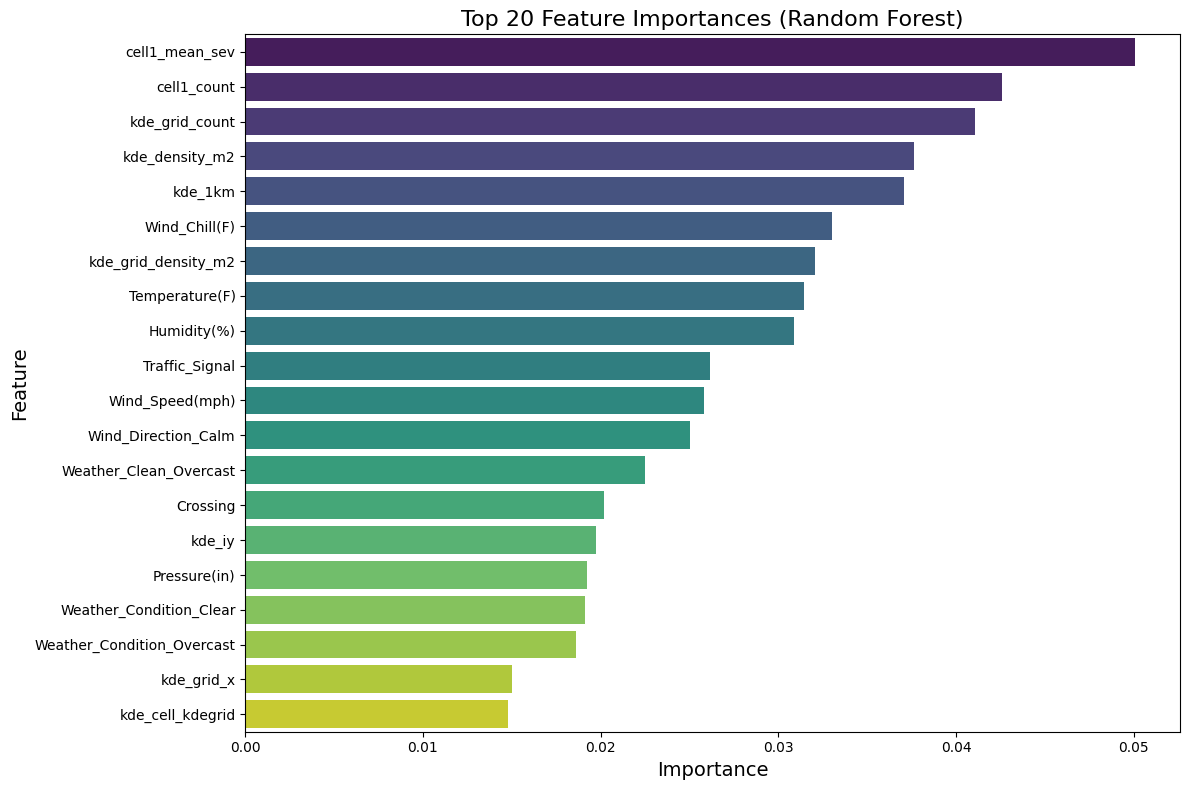

In [38]:
# Get feature names after one-hot encoding
cat_features = model.named_steps['preprocess'] \
    .named_transformers_['cat'] \
    .get_feature_names_out(categorical)

# Combine all column names
feature_names = np.concatenate([numeric, boolean, cat_features])

# Get importances from the random forest
importances = model.named_steps['rf'].feature_importances_

# Create a DataFrame for easy sorting and plotting
feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot top 20
plt.figure(figsize=(12, 8))
sns.barplot(
    data=feat_imp.head(20),
    x='Importance',
    y='Feature',
    palette='viridis'
)

plt.title("Top 20 Feature Importances (Random Forest)", fontsize=16)
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.tight_layout()
plt.show()

### Model 2: XG Boost

In [ ]:
# Model 2 - XG Boost:

import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

# Encode target labels as XGBoost is 0-indexed while our data is 1-4
le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.3, random_state=1, stratify=y_enc)

xgb_model = Pipeline([
    ('preprocess', preprocessor),
    ('xgb', xgb.XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1, # perform hyper-parameter tuning to find optimal learning rate
        subsample=0.8,
        colsample_bytree=0.8,
        objective='multi:softmax',
        num_class=4,
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42,
        n_jobs=-1
    ))
])

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Model Accuracy:", round(accuracy_score(y_test, y_pred_xgb), 4))
print("\nXGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("\nXGBoost Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

c:\Users\Randy\miniconda3\envs\SevPrediction\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:52:00] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Randy\miniconda3\envs\SevPrediction\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


XGBoost Model Accuracy: 0.71

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.80      0.79     20209
           1       0.70      0.59      0.64     20209
           2       0.65      0.77      0.70     20209
           3       0.72      0.68      0.70     20208

    accuracy                           0.71     80835
   macro avg       0.71      0.71      0.71     80835
weighted avg       0.71      0.71      0.71     80835


XGBoost Confusion Matrix:
 [[16115  1876  1399   819]
 [ 2829 11916  3116  2348]
 [  898  1527 15548  2236]
 [  779  1710  3902 13817]]


### Model 3: Attention-based Neural Network

### Final Model

In [ ]:
# cross validation and parameter tuning using final model

### Analysis

In [ ]:
# feature importance